In [1]:
import torchvision 
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as transforms   
import torch.optim as optim
from torchvision.transforms import RandomRotation
from torchvision.transforms import Pad
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from PIL import Image
from numpy.linalg import norm
from torch.cuda.random import device_count
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split
import torch.optim as optim
import torchvision.transforms as transforms 
import torchvision 
import math
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import torch.nn.utils.prune as prune
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.autograd import Variable
#!pip install opacus


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
transform1 = transforms.Compose(
    [    
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, 4),
    transforms.ToTensor(),
    transforms.Normalize((0.4, 0.4822, 0.4465), (0.247, 0.243, 0.261)),   
    ])
dataset = torchvision.datasets.CIFAR10(root='./', train=True,download=True,transform = transform1)
validset = torchvision.datasets.CIFAR10(root='./', train=True,download=True, transform = transform) 
valid = list(range(40000, 50000,1))
validset1 = torch.utils.data.Subset(validset, valid)
validloader = torch.utils.data.DataLoader(validset1, shuffle=True, num_workers=4,batch_size = 100)
testset = torchvision.datasets.CIFAR10(root='./data', train = False, download=True, transform=transform)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from torch.autograd import Variable

__all__ = ['ResNet', 'resnet20', 'resnet32', 'resnet44', 'resnet56', 'resnet110', 'resnet1202']

def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])


def resnet32():
    return ResNet(BasicBlock, [5, 5, 5])


def resnet44():
    return ResNet(BasicBlock, [7, 7, 7])


def resnet56():
    return ResNet(BasicBlock, [9, 9, 9])


def resnet110():
    return ResNet(BasicBlock, [18, 18, 18])


def resnet1202():
    return ResNet(BasicBlock, [200, 200, 200])


def test(net):
    import numpy as np
    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    print("Total number of params", total_params)
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))


if __name__ == "__main__":
    for net_name in __all__:
        if net_name.startswith('resnet'):
            print(net_name)
            test(globals()[net_name]())
            print()

resnet20
Total number of params 269722
Total layers 20

resnet32
Total number of params 464154
Total layers 32

resnet44
Total number of params 658586
Total layers 44

resnet56
Total number of params 853018
Total layers 56

resnet110
Total number of params 1727962
Total layers 110

resnet1202
Total number of params 19421274
Total layers 1202



In [7]:
model = resnet20()
torch.save(model.state_dict(), "resnet20dynamicstart")


average accuracy after 99 iterations:17.219
[0.00387552]
[17.219]
average accuracy after 99 iterations:18.431
[0.00387552 0.00387809]
[17.219 18.431]
average accuracy after 99 iterations:17.392000000000003
[0.00387552 0.00387809 0.00393021]
[17.219 18.431 17.392]
average accuracy after 99 iterations:16.827
[0.00387552 0.00387809 0.00393021 0.00412025]
[17.219 18.431 17.392 16.827]
average accuracy after 99 iterations:17.91
[0.00387552 0.00387809 0.00393021 0.00412025 0.00379609]
[17.219 18.431 17.392 16.827 17.91 ]
average accuracy after 99 iterations:18.023000000000003
[0.00387552 0.00387809 0.00393021 0.00412025 0.00379609 0.00386979]
[17.219 18.431 17.392 16.827 17.91  18.023]
average accuracy after 99 iterations:18.121999999999996
[0.00387552 0.00387809 0.00393021 0.00412025 0.00379609 0.00386979
 0.00383026]
[17.219 18.431 17.392 16.827 17.91  18.023 18.122]
average accuracy after 99 iterations:17.988
[0.00387552 0.00387809 0.00393021 0.00412025 0.00379609 0.00386979
 0.00383026 0

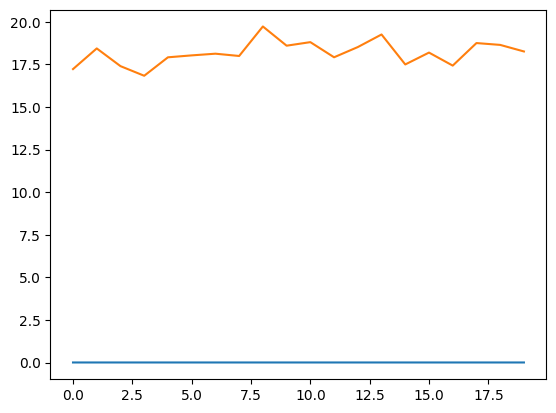

In [8]:
import random
def l2normupdated(data,size):  
    count = 0
    total = 0
    avg = np.array([])
    for i in range(size):
        if i ==0:
            avg = data[i]
        else:
            avg = avg+data[i]
    avg = avg/size
    for i in range(size):
        data1 = avg-data[i]
        total += (np.linalg.norm(data1)/np.linalg.norm(data[i]))
    return total/size



toplot = np.array([])
toplot2 = np.array([])

for i in range(20):
    indices = torch.randperm(len(dataset))[:20000]
    #indiices = list(range(0, 20000,1))
    matrix = np.array([])
    count = 1
    avg = 0 
    topacc = 0
    testloader = torch.utils.data.DataLoader(testset, shuffle=True, num_workers=2, batch_size = 100)
    for a in range(10):
        start_index = a * 2000
        end_index = start_index + 2000
        sample = indices[start_index:end_index]
        trainset1 = torch.utils.data.Subset(dataset, sample)
        modelloader = torch.utils.data.DataLoader(trainset1, shuffle=False, num_workers=2, batch_size = 2000)
        #model gen
        model = resnet20()
        model.load_state_dict(torch.load("/notebooks/resnet20dynamicstart"))
        model.to(device) 
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, weight_decay = 1e-03)
        ################################################################
          ################
          #training model
          ####################
        train_losslist = []
        n_epochs = [*range(10)]
        valid_loss_min = np.Inf # track change in validation loss
        for epoch in n_epochs:
            train_loss = 0.0
            train_loss1 = 0.0
            valid_loss = 0.0   
            model.train()
            for data, target in modelloader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()*data.size(0)

        ########################
        # testing model #
        ######################### 
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        test_loss = 0.
        train_on_gpu = torch.cuda.is_available()
        model.eval()
        # iterate over test data
        for data, target in testloader:

            # move tensors to GPU if CUDA is available
            data, target = data.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            loss = criterion(output, target)
            # update test loss 
            test_loss += loss.item()*data.size(0)
            # convert output probabilities to predicted class
            _, pred = torch.max(output, 1)    
            # compare predictions to true label
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
            # calculate test accuracy for each object class
            for i in range(100):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
        # average test loss     
        avg += (100. * np.sum(class_correct) / np.sum(class_total))
        ##############################################################################
        #model stacking
        arr = np.array([])
        for name, param in model.named_parameters():
            temp = param.cpu().detach().numpy()
            bruh = temp.flatten()
            arr =np.concatenate((arr,bruh),axis = 0)
        arr =np.reshape(arr, (1,-1))
        if matrix.size == 0:
            matrix = arr
        else: 
            matrix = np.append(matrix, arr, axis = 0)
            
    print(f"average accuracy after {i} iterations:{avg/10}")
    l2norm = l2normupdated(matrix,10)
    if toplot.size == 0:
        toplot = np.array([l2norm])
    else: 
        toplot = np.append(toplot, l2norm)
    if toplot2.size == 0:
        toplot2 = np.array([avg/10])
    else: 
        toplot2 = np.append(toplot2, avg/10)
    print(toplot)
    print(toplot2)
    torch.save(model.state_dict(), "dynamicstart")  
plt.plot(toplot)
plt.plot(toplot2)
np.save('l2normresnetdynamicnomomentum1e-03reg20it.npy', toplot)
np.save('accresnetdynamicnomomentum1e-03reg20it.npy', toplot2)

In [ ]:
import random
def l2normupdated(data,size):
    count = 0
    total = 0
    avg = np.array([])
    for i in range(size):
        if i ==0:
            avg = data[i]
        else:
            avg = avg+data[i]
    avg = avg/size
    for i in range(size):
        data1 = avg-data[i]
        total += (np.linalg.norm(data1)/np.linalg.norm(data[i]))
    return total/size

toplot = np.array([])
toplot2 = np.array([])
for a in range(39,75):
    print(a)
    matrix = np.array([])
    count = 1
    avg = 0 
    topacc = 0
    testloader = torch.utils.data.DataLoader(testset, shuffle=True, num_workers=2, batch_size = 100)
    for i in range(5): 
        indices = torch.randperm(len(dataset))[:20000]
        #removing indices
        """
        
        indices = list(range(0, 20000,1))
        indices_to_remove = random.sample(range(len(indices)), 1)
        indices_to_remove.sort(reverse=True)
        for index in indices_to_remove:
            del indices[index]
        """
        #print(np.shape(indices))
        #dataset defined
        trainset1 = torch.utils.data.Subset(dataset, indices)
        modelloader = torch.utils.data.DataLoader(trainset1, shuffle=False, num_workers=2, batch_size = 5000)
        #model define
        model = resnet20()
        model.load_state_dict(torch.load("/notebooks/resnet20start"))
        model.to(device) 
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr = 0.1,weight_decay = 1e-02)
      ################
      #training model
      ####################
        train_losslist = []
        n_epochs = [*range(a)]
        valid_loss_min = np.Inf # track change in validation loss
        for epoch in n_epochs:
            train_loss = 0.0
            train_loss1 = 0.0
            valid_loss = 0.0   
            model.train()
            for data, target in modelloader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()*data.size(0)

        ########################
        # testing model #
        ######################### 
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        test_loss = 0.
        train_on_gpu = torch.cuda.is_available()
        model.eval()
        # iterate over test data
        for data, target in testloader:
            
            # move tensors to GPU if CUDA is available
            data, target = data.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            loss = criterion(output, target)
            # update test loss 
            test_loss += loss.item()*data.size(0)
            # convert output probabilities to predicted class
            _, pred = torch.max(output, 1)    
            # compare predictions to true label
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
            # calculate test accuracy for each object class
            for i in range(100):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
        # average test loss     
        avg += (100. * np.sum(class_correct) / np.sum(class_total))
        arr = np.array([])
        for name, param in model.named_parameters():
            temp = param.cpu().detach().numpy()
            bruh = temp.flatten()
            arr =np.concatenate((arr,bruh),axis = 0)
        arr =np.reshape(arr, (1,-1))
        if matrix.size == 0:
            matrix = arr
        else: 
            matrix = np.append(matrix, arr, axis = 0)
    print(matrix.shape)
    print(f"average accuracy after {a} iterations:{avg/5}")
    l2norm = l2normupdated(matrix,5)
    if toplot.size == 0:
        toplot = np.array([l2norm])
    else: 
        toplot = np.append(toplot, l2norm)
    if toplot2.size == 0:
        toplot2 = np.array([avg/5])
    else: 
        toplot2 = np.append(toplot2, avg/5)
    print(toplot)
    print(toplot2)
    np.save('resnetpercentl2norm39-75it20k5batchnomomentum1e-02weightdecay.npy', toplot)
    np.save('resnetpercentacc39-75it20k5kbatchnomomentum1e-02weightdecay.npy', toplot2)
plt.plot(toplot)
plt.plot(toplot2)

39
(5, 269722)
average accuracy after 39 iterations:41.406000000000006
[0.01221284]
[41.406]
40
(5, 269722)
average accuracy after 40 iterations:39.472
[0.01221284 0.01208785]
[41.406 39.472]
41
(5, 269722)
average accuracy after 41 iterations:43.21
[0.01221284 0.01208785 0.01363063]
[41.406 39.472 43.21 ]
42
(5, 269722)
average accuracy after 42 iterations:41.992
[0.01221284 0.01208785 0.01363063 0.01256194]
[41.406 39.472 43.21  41.992]
43
(5, 269722)
average accuracy after 43 iterations:41.206
[0.01221284 0.01208785 0.01363063 0.01256194 0.01335271]
[41.406 39.472 43.21  41.992 41.206]
44
(5, 269722)
average accuracy after 44 iterations:42.989999999999995
[0.01221284 0.01208785 0.01363063 0.01256194 0.01335271 0.01426083]
[41.406 39.472 43.21  41.992 41.206 42.99 ]
45
(5, 269722)
average accuracy after 45 iterations:43.612
[0.01221284 0.01208785 0.01363063 0.01256194 0.01335271 0.01426083
 0.01401402]
[41.406 39.472 43.21  41.992 41.206 42.99  43.612]
46
(5, 269722)
average accuracy

(69,)
(68,)
(95,)


"\nmatrix2 = np.load('/notebooks/l2norm65to75it20k.npy', allow_pickle = True)\nmatrix = np.append(toplot2, matrix2)\nprint(matrix)\nnp.save('/notebooks/acc65to75it20k.npy', matrix2)\n\nmatrix2 = np.load('/notebooks/l2norm65to75it20k.npy', allow_pickle = True)\nmatrix = np.append(toplot, matrix2)\n\nnp.save('/notebooks/l2norm75it20k.npy', matrix)\n"

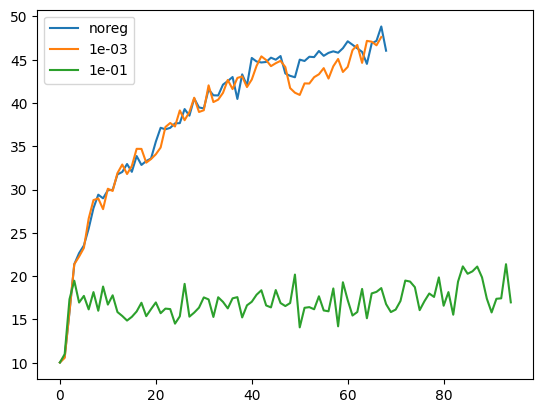

In [40]:

#plt.plot(toplot)


#np.save('l2norm62-75it5krandimgnet.npy', toplot)
#np.save('acc62-75it5krandimgnet.npy', toplot2)
#toplot = np.load('l2norm75it5krandimgnet.npy', allow_pickle = True)
"""

toplot2 = np.load('/notebooks/resnetpercentacc75it20k5kbatchnomomentum1e-03weightdecay.npy', allow_pickle = True)
matrix2 = np.load('/notebooks/resnetpercentacc34-75it20k5kbatchnomomentum1e-03weightdecay.npy', allow_pickle = True)
matrix = np.append(toplot2, matrix2)
print(matrix)
np.save('/notebooks/resnetpercentacc75it20k5kbatchnomomentum1e-03weightdecay.npy', matrix)
"""

toplot = np.load('/notebooks/resnetpercentacc75it20k5kbatchnomomentum.npy', allow_pickle = True)
toplot2 = np.load('/notebooks/resnetpercentacc75it20k5kbatchnomomentum1e-03weightdecay.npy', allow_pickle = True)
toplot3 = np.load('/notebooks/resnetpercentacc75it20k5kbatchnomomentum1e-01weightdecay.npy', allow_pickle = True)
toplot4 = np.load('/notebooks/l2norm75it20krandpercentnomomentum1e-01reg.npy', allow_pickle = True)
print(np.shape(toplot))
print(np.shape(toplot2))
print(np.shape(toplot3))


plt.plot(toplot, label = 'noreg')
plt.plot(toplot2, label = '1e-03')
plt.plot(toplot3, label = '1e-01')
plt.legend(loc="upper left")
#plt.plot(toplot4)



"""
matrix2 = np.load('/notebooks/l2norm65to75it20k.npy', allow_pickle = True)
matrix = np.append(toplot2, matrix2)
print(matrix)
np.save('/notebooks/acc65to75it20k.npy', matrix2)

matrix2 = np.load('/notebooks/l2norm65to75it20k.npy', allow_pickle = True)
matrix = np.append(toplot, matrix2)

np.save('/notebooks/l2norm75it20k.npy', matrix)
"""

10k 100 epoch 0.01 lr avg acc: 71.93 

10k 50 epoch 0.1 lr avg acc: 75.72

10k 100 epoch 0.1 lr avg acc: 77.04

10k 100 epoch 0.1 lr avg acc: 76.88

10k 100 epoch 0.05 lr avg acc: 75.87

10k 100 epoch 0.1 lr 0.25 grad: 75.62

10k 100 epoch 0.1 lr 0.1 grad: 76.48

10k 100 epoch 0.1 lr 0.05 grad: 74.8

10k 200 epoch 0.1 lr 0.05 grad: 77.3


1k 100 epoch 0.01 lr avg acc: 71.06

1k 50 epoch 0.1 lr avg acc: 73.36

1k 100 epoch 0.1 lr avg acc: 73.67

1k 100 epoch 0.05 lr avg acc: 73.55

1k 100 epoch 0.25 grad 0.1 lr : 73.64



20k 50 epoch 0.1 lr avg acc: 75.9288

20k 50 epoch 0.1 lr avg acc: 76.84

20k 100 epoch 0.1 lr avg acc: 77.44

20k 100 epoch 0.1 lr 0.25 grad: 77.24

20k 100 epoch 0.1 lr 0.1 grad: 76.8


10k 10 point removal 100 epoch 0.1 lr no grad: 77.13
10k 100 point removal 100 epoch 0.1 lr no grad: 77.07
10k 1000 point removal 100 epoch 0.1 lr no grad: 76.983
10k 2500 point removal 100 epoch 0.1 lr no grad: 76.86
10k 5000 point removal 100 epoch 0.1 lr no grad: 76.56




